In [1]:
# SCRTP: module load Anaconda3
# run as
# python ising_data_generate.py 11234567 16 3.0 2.0 -0.5 5

import numpy as np
import matplotlib.pyplot as plt
import random
import pickle as pkl
import imageio
import time
import os
import sys

###############################################################################
###############################################################################
# CLASS DEFINITION
class IsingLattice:
    
###############################################################################
    # Initializer. Parameter n corresponds to the lattice size. 
    def __init__(self,lattice_size,J,h):
        
        # In order to easily access the parameters: 
        self.lattice_size = lattice_size
        self.num_sites = lattice_size*lattice_size
        self.J = J
        self.h = h
        
        # We randomly initialize the lattice with 0's and 1's
        lattice_state = np.zeros((self.lattice_size,self.lattice_size))
        for i in np.arange(self.lattice_size):
            for j in np.arange(self.lattice_size):
                lattice_state[i][j] = random.getrandbits(1)

        lattice_state = np.where(lattice_state==0, -1, lattice_state)
        
        # We store the configuration 
        self.lattice_state = lattice_state
    
    # THE METHODS 

###############################################################################
    # Plot function. This will help us easily see the lattice configuration.
    def plot_lattice(self, print_info=False): 
        # print_info is Boolean. If it is true then we print info.
        
        plt.figure()
        plt.imshow(self.lattice_state)
        plt.show()
        if print_info:
            self.print_info()
    
###############################################################################
    # Now we define print_info() method. 
    # It will print all the information about the lattice.
    def print_info(self):
        
        print("Lattice size: ", self.lattice_size , \
            "x", self.lattice_size, ". J: ", self.J, " h: ", self.h )
    
###############################################################################
    # A spin flipper at site (i,j) method
    def flip_spin(self,i,j):
        self.lattice_state[i,j] *= -1
        
###############################################################################
    # Calculating energy of one spin at site (i,j)
    def spin_energy(self,i,j):
        
        # Spin at (i,j)
        spin_ij = self.lattice_state[i,j]
        
        # Now we need to deal with the boundary spins. 
        # We apply periodic boundary conditions.  
        sum_neighbouring_spins = \
            self.lattice_state[(i+1)%self.lattice_size, j] + \
            self.lattice_state[i, (j+1)%self.lattice_size] + \
            self.lattice_state[(i-1)%self.lattice_size, j] + \
            self.lattice_state[i, (j-1)%self.lattice_size]
        
        # We calculate the energy terms for site 
        interaction_term = (- self.J * spin_ij * sum_neighbouring_spins)
        
        # This part is added so that in case 
        # there is no external magnetic field, i.e. h = 0
        # then we do not need the computer to do the computation
        # for the magnetic term. 
        if self.h == 0:
            return interaction_term
        else:
            magnetic_field_term = - (self.h * spin_ij)
            return magnetic_field_term + interaction_term
    
###############################################################################
    # Calculating Total Lattice Energy
    def energy(self):
        
        # Initialize energy as 0.
        E = 0.0
        
        # We iterate through the lattice
        for i in np.arange(self.lattice_size):
            for j in np.arange(self.lattice_size):
                E = E + self.spin_energy(i,j)
                
        # But we counted neighbours twice here.
        #  So we need to correctly return. 
        # We divide by two 
        E = E / (2.0) / self.num_sites
        if self.h==0:
            return E
        else: 
            # We add the magnetic field term |IS THERE A 1/2 FACTOR HERE?
            E = (E - self.h * np.sum(self.lattice_state)) / self.num_sites
            return E
    
###############################################################################
    # Net magnetization
    def magnetization(self):
        return  np.sum(self.lattice_state)/ (self.num_sites)
        
###############################################################################
 # Correlation Function 
    '''   
    def correlation(self,r):
    
        # r is the distance of the two spins of which the correlation function
        # is calculated
        correlation_sum = 0
        for i in np.arange(self.lattice_size):
            correlation = self.lattice_state[i,i]*self.lattice_state[i,(i-r)\
                            %self.lattice_size] + \
                        self.lattice_state[i,i]*self.lattice_state[i,(i+r)\
                            %self.lattice_size] + \
                        self.lattice_state[i,i]*self.lattice_state[(i-r)\
                            %self.lattice_size,i] + \
                        self.lattice_state[i,i]*self.lattice_state[(i+r)\
                            %self.lattice_size,i]
            correlation_sum += correlation
        return correlation_sum/(4*self.lattice_size)
    '''
    def correlation(self,r):
        # r is the distance of the two spins of which the correlation function
        # is calculated
        
        
        correlation_sum = 0
        for i in np.arange(self.lattice_size):
            for j in np.arange(self.lattice_size):
                correlation = self.lattice_state[i,j]*self.lattice_state[i,(j-r)\
                            %self.lattice_size] + \
                        self.lattice_state[i,j]*self.lattice_state[i,(j+r)\
                            %self.lattice_size] + \
                        self.lattice_state[i,j]*self.lattice_state[(i-r)\
                            %self.lattice_size,j] + \
                        self.lattice_state[i,j]*self.lattice_state[(i+r)\
                            %self.lattice_size,j]
                correlation_sum += correlation
        return correlation_sum/(4*self.num_sites)
    
###############################################################################

    def correlation_function(self, plot=False):
        
        correlation_func = np.zeros(self.lattice_size)
        for i in np.arange(self.lattice_size):
            correlation_func[i] = self.correlation(i)
        correlation_func -= self.magnetization()**2
        if plot:
            plt.plot(correlation_func)
        return correlation_func

###############################################################################        
###############################################################################
# END OF CLASS

###############################################################################
# Boltzmann constant is fixed to 1.
def scan_lattice(ising_lattice, temperature):

    for k in np.arange(ising_lattice.num_sites):
        
        # POWER OF 2 CASE
        # We choose a random site
        #lattice_size_power = int(np.log2(ising_lattice.lattice_size))
        #i = random.getrandbits(lattice_size_power)
        #j = random.getrandbits(lattice_size_power)

        # RANDOM INT CASE        
        # We choose a random site  
        i = int(ising_lattice.lattice_size * random.random())      
        j = int(ising_lattice.lattice_size * random.random())  

        # We calculate the energy difference if we flip
        energy_initial = ising_lattice.spin_energy(i,j)
        ising_lattice.flip_spin(i,j)
        energy_final = ising_lattice.spin_energy(i,j)
        energy_change = energy_final - energy_initial
        # For convenience we flip it back to the original
        ising_lattice.flip_spin(i,j)
        
        # Then we should flip the spin
        if temperature != 0:
            if energy_change<=0 or \
                np.random.rand()<=np.exp(-energy_change/temperature):
                # If the Metropolis Criteria holds, swap. 
                ising_lattice.flip_spin(i,j)

###############################################################################
def monte_carlo_simulation(ising_lattice,\
                           temperature, num_scans,\
                           num_scans_4_equilibrium, \
                           frequency_sweeps_to_collect_magnetization,\
                           plot_result = False,print_info=False):

    start_time = time.time()
    
    # The first three arguments are self-explanatory. 
    # The last one is the number of scans we need to do
    # Before we reach equilibrium. Therefore we do not
    # need to collect data at these steps. 
    if print_info:
        ising_lattice.print_info()
    
    # We start by collecting <E> and <m> data. In order to 
    # calculate these, we record energy and magnetization 
    # after we reach equilibrium.
    
    # The total number of records, both first and last point included
    TOTAL_NUM_RECORDS = \
        int(num_scans/frequency_sweeps_to_collect_magnetization)+1
    energy_records = np.zeros(TOTAL_NUM_RECORDS)
    magnetization_records = np.zeros(TOTAL_NUM_RECORDS)
    correlation_records = np.zeros([TOTAL_NUM_RECORDS,ising_lattice.lattice_size])
    increment_records = 0
    
    # We will return this n-dimensional 
    lattice_configs = np.zeros((TOTAL_NUM_RECORDS,\
                               ising_lattice.lattice_size,\
                               ising_lattice.lattice_size))
    # LOG feature
    print(" equilibrating to T=", temperature)
    for equ in np.arange(num_scans_4_equilibrium):
        scan_lattice(ising_lattice,temperature)
    # LOG feature
    print(" reached T=", temperature)

    for k in np.arange(num_scans+frequency_sweeps_to_collect_magnetization):
        scan_lattice(ising_lattice, temperature)
        if k%frequency_sweeps_to_collect_magnetization==0:
            energy_records[increment_records] = ising_lattice.energy()
            magnetization_records[increment_records] = \
                ising_lattice.magnetization()
            lattice_configs[increment_records] = ising_lattice.lattice_state
            correlation_records[increment_records] = \
                ising_lattice.correlation_function(True)
            increment_records += 1
            # LOG feature
            print(" ", temperature, increment_records)
    
    # Now we can get the <E> and <m>
    print("For temperature= ", temperature, "MC simulation is executed in: ", \
        " %s seconds " % round(time.time() - start_time,2))
    
    if plot_result:
        ising_lattice.plot_lattice()
    
    return lattice_configs, energy_records, magnetization_records, correlation_records


In [2]:
test = IsingLattice(50,-1,0)

 equilibrating to T= 2.5
 reached T= 2.5
  2.5 1
  2.5 2
  2.5 3
For temperature=  2.5 MC simulation is executed in:   37.86 seconds 


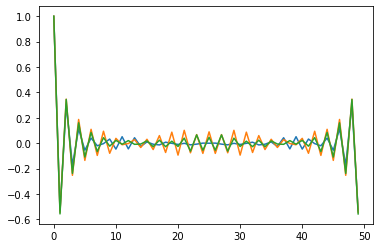

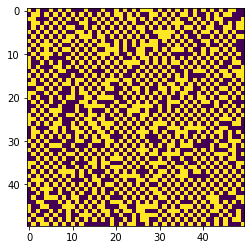

In [3]:
test_lattice, mean_en, mean_m, corr = monte_carlo_simulation(test, 2.5, 1000, 1000, 500, True,False)

 equilibrating to T= 25
 reached T= 25
  25 1
  25 2
  25 3
For temperature=  25 MC simulation is executed in:   35.46 seconds 


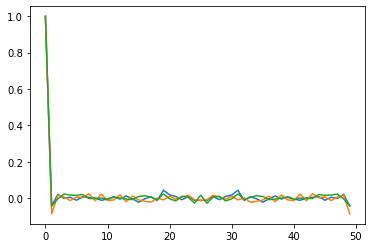

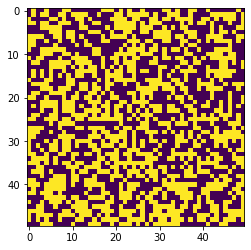

In [4]:
test_lattice, mean_en, mean_m, corr = monte_carlo_simulation(test, 25, 1000, 1000, 500, True,False)

 equilibrating to T= 1
 reached T= 1
  1 1
  1 2
  1 3
For temperature=  1 MC simulation is executed in:   39.72 seconds 


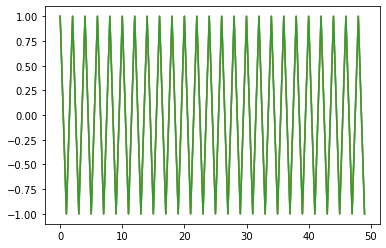

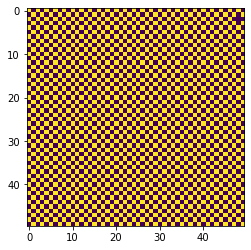

In [5]:
test_lattice, mean_en, mean_m, corr = monte_carlo_simulation(test, 1, 1000, 1000, 500, True,False)